**Imports**

In [7]:
# Third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import seaborn as sns

# Goggle
from goggle.GoggleModel import GoggleModel

# Synthcity
from synthcity.plugins.core.dataloader import GenericDataLoader
from synthcity.plugins import Plugins

**Load data**

In [8]:
dataset = "red_wine"
X = pd.read_csv("../data/winequality-red.csv", sep=';')
ind = list(range(len(X.columns)))

ind = [x for x in ind if x != X.columns.get_loc("quality")]
col_list = X.columns[ind]
ct = ColumnTransformer(
    [("scaler", StandardScaler(), col_list)], remainder="passthrough"
)

X_ = ct.fit_transform(X)
X = pd.DataFrame(X_, index=X.index, columns=X.columns)

X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5.0
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,5.0
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,5.0
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,6.0
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5.0


**Fit model**

In [9]:
X_train, X_test = train_test_split(X, random_state=0, test_size=0.2, shuffle=True)

gen = GoggleModel(
    ds_name=dataset,
    input_dim=X_train.shape[1],
    encoder_dim=64,
    encoder_l=2,
    het_encoding=True,
    decoder_dim=64,
    decoder_l=2,
    threshold=0.05,
    decoder_arch="gcn",
    graph_prior=None,
    prior_mask=None,
    device="cpu",
    beta=0.01,
    learning_rate=0.01,
    seed=0,
)
gen.model

Goggle(
  (learned_graph): LearnedGraph(
    (act): Sigmoid()
    (threshold): Threshold(threshold=0.05, value=0)
  )
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=12, out_features=64, bias=True)
      (1): ReLU()
    )
    (encode_mu): Linear(in_features=64, out_features=12, bias=True)
    (encode_logvar): Linear(in_features=64, out_features=12, bias=True)
  )
  (graph_processor): GraphInputProcessorHomo()
  (decoder): GraphDecoderHomo(
    (decoder): Sequential(
      (0): GraphConv(
        in=64, out=32, normalization=both
        (_activation): Tanh()
      )
      (1): GraphConv(in=32, out=1, normalization=both, activation=None)
    )
  )
)

In [10]:
gen.fit(X_train)

[Epoch 100/1000, patience 10] train: 5.707, val: 5.707
[Epoch 200/1000, patience  1] train: 4.798, val: 4.330
[Epoch 300/1000, patience  2] train: 4.271, val: 3.843
[Epoch 400/1000, patience  3] train: 3.112, val: 3.100
Training terminated after 484 epochs


**Evaluate synthetic data**

In [14]:
X_synth = gen.sample(X_test)
X_synth.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-1.328270,0.215122,-1.026183,-2.555387,-1.031922,-0.850063,-0.695175,-2.029916,-0.898060,-0.377655,-0.512498,5.0
1,-2.790882,-0.591256,-2.161970,-1.224983,-0.777843,0.823202,0.777534,-1.996126,-0.217242,0.007535,-1.531444,4.0
2,-0.597154,-2.246562,0.007121,-0.437046,-1.330437,-0.293706,-0.172768,-1.453438,-2.594940,-0.464682,-0.699896,5.0
3,-0.769644,-0.957911,-0.459712,0.735353,0.674599,0.501745,0.437071,0.026594,-0.390367,0.306457,-1.127340,5.0
4,-0.923007,-1.134059,-0.003751,0.721594,1.073447,-1.269862,-1.503066,-1.798129,1.027405,1.110792,2.232098,7.0


In [17]:
X_synth_loader = GenericDataLoader(
    X_synth,
    target_column="quality",
)
X_test_loader = GenericDataLoader(
    X_test,
    target_column="quality",
)

res = gen.evaluate_synthetic(X_synth_loader, X_test_loader)

print(f"Quality: {res[0]:.3f}")
print(f"Detection: {res[2]:.3f}")
print(
    f"Performance on real: {res[1][0]:.3f}, on synth: {res[1][1]:.3f}, diff: {(res[1][0] - res[1][1]):.3f}"
)

cache loaded
cache loaded
cache loaded
Quality: 0.572
Detection: 0.698
Performance on real: 0.513, on synth: 0.737, diff: -0.224


In [22]:
def multi_train(runs=10):
    
    avg_quality = []
    avg_detection = []
    avg_utility = []

    for _ in range(runs):
        X_train, X_test = train_test_split(X, random_state=0, test_size=0.2, shuffle=True)

        gen = GoggleModel(
            ds_name=dataset,
            input_dim=X_train.shape[1],
            encoder_dim=64,
            encoder_l=2,
            het_encoding=True,
            decoder_dim=64,
            decoder_l=2,
            threshold=0.05,
            decoder_arch="gcn",
            graph_prior=None,
            prior_mask=None,
            device="cpu",
            beta=0.01,
            learning_rate=0.01,
            seed=0,
        )
        
        gen.fit(X_train)

        X_synth = gen.sample(X_test)

        X_synth_loader = GenericDataLoader(
            X_synth,
            target_column="quality",
        )
        X_test_loader = GenericDataLoader(
            X_test,
            target_column="quality",
        )

        res = gen.evaluate_synthetic(X_synth_loader, X_test_loader)

        print(f"Quality: {res[0]:.3f}")
        print(f"Detection: {res[2]:.3f}")
        print(
            f"Performance on real: {res[1][0]:.3f}, on synth: {res[1][1]:.3f}, diff: {(res[1][0] - res[1][1]):.3f}"
        )

        avg_quality.append(res[0])
        avg_detection.append(res[2])
        avg_utility.append(res[1][0] - res[1][1])

    print(f" Average Quality (across 10 runs): {sum(avg_quality)/runs:.3f} +/- {np.std(avg_quality):.3f}")
    print(f"Average Detection (across 10 runs): {sum(avg_detection)/runs:.3f} +/- {np.std(avg_detection):.3f}")
    print(
        f"Average Performance difference on real versus synthetic (across 10 runs): {sum(avg_utility)/runs:.3f} +/- {np.std(avg_utility):.3f}"
    )

    return (avg_quality, avg_detection, avg_utility)

In [25]:
results = multi_train(10)

[Epoch 100/1000, patience 10] train: 5.707, val: 5.707
[Epoch 200/1000, patience  1] train: 4.798, val: 4.330
[Epoch 300/1000, patience  2] train: 4.271, val: 3.843
[Epoch 400/1000, patience  3] train: 3.112, val: 3.100
Training terminated after 484 epochs
Quality: 0.577
Detection: 0.743
Performance on real: 0.513, on synth: 0.737, diff: -0.224
[Epoch 100/1000, patience 10] train: 5.707, val: 5.707
[Epoch 200/1000, patience  1] train: 4.798, val: 4.330
[Epoch 300/1000, patience  2] train: 4.271, val: 3.843
[Epoch 400/1000, patience  3] train: 3.112, val: 3.100
Training terminated after 484 epochs
Quality: 0.577
Detection: 0.743
Performance on real: 0.513, on synth: 0.737, diff: -0.224
[Epoch 100/1000, patience 10] train: 5.707, val: 5.707
[Epoch 200/1000, patience  1] train: 4.798, val: 4.330
[Epoch 300/1000, patience  2] train: 4.271, val: 3.843
[Epoch 400/1000, patience  3] train: 3.112, val: 3.100
Training terminated after 484 epochs
Quality: 0.577
Detection: 0.743
Performance on re

**Generate TSNE plots**

In [7]:
X_test["label"] = "Original"
X_synth["label"] = "Synthetic"

concat_df = pd.concat([X_test, X_synth], axis=0)
y_data = concat_df["label"]
x_data = concat_df.drop(["label", "quality"], axis=1)

In [8]:
tsne = TSNE(n_components=2, verbose=0, random_state=0)
z = tsne.fit_transform(x_data)
df = pd.DataFrame()
df["y"] = y_data
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]

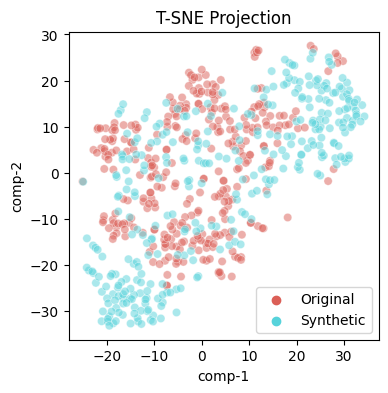

In [9]:
plt.figure(figsize=(4, 4))
sns.scatterplot(
    x="comp-1",
    y="comp-2",
    hue=df.y.tolist(),
    palette=sns.color_palette("hls", 2),
    alpha=0.5,
    data=df,
).set(title=f"T-SNE Projection")
plt.xlabel("comp-1")
plt.ylabel("comp-2")
plt.legend()

plt.show()

**Visualise adjacency matrix**

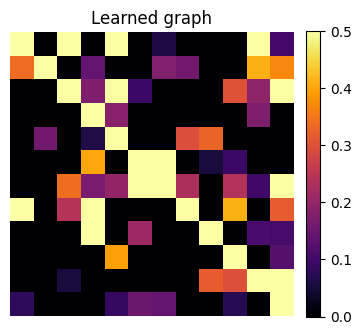

In [10]:
adj_matrix = gen.model.learned_graph(100).cpu().detach().numpy()
plt.figure(figsize=(4, 4))
im = plt.imshow(adj_matrix, cmap="inferno", interpolation="nearest", vmin=0, vmax=0.5)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Learned graph")
plt.axis("off")
plt.show()